# 03 FEM Simulation

演示 FEM 求解器的运行，展示动力学响应和结构变形。

In [13]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ????????? notebooks ???? notebook
cwd = Path.cwd().resolve()
candidates = [cwd, cwd.parent]
project_root = next(
    (p for p in candidates if (p / 'PyFEM_Dynamics').exists() and (p / 'notebooks' / 'utils').exists()),
    None,
)
if project_root is None:
    raise FileNotFoundError('??????????????????? notebooks/utils ? PyFEM_Dynamics')

for p in [project_root / 'notebooks', project_root / 'PyFEM_Dynamics']:
    p_str = str(p)
    if p_str not in sys.path:
        sys.path.insert(0, p_str)

from utils.data_loader import load_structure_config, get_time_array
from utils.visualizer import plot_deformation, plot_time_history
from utils.config import STRUCTURE_PATH, DT

from core.node import Node
from core.element import TrussElement2D
from core.material import Material
from core.section import Section
from solver.assembler import Assembler
from solver.integrator import NewmarkBetaSolver


## 构建结构模型

In [12]:
# 加载结构配置
structure = load_structure_config(STRUCTURE_PATH)

# 创建节点
nodes = {}
for n in structure['nodes']:
    node = Node(n['id'], n['coords'][0], n['coords'][1])
    nodes[n['id']] = node

# 创建材料
materials = {}
for mat in structure['materials']:
    materials[mat['name']] = Material(mat['E'], mat['rho'], mat['nu'])

# 创建截面
sections = {}
sections['default'] = Section(0.005, 0.0)

# 创建单元
elements = []
for e in structure['elements']:
    n1 = nodes[e['nodes'][0]]
    n2 = nodes[e['nodes'][1]]
    mat = materials[e['material']]
    sec = sections['default']
    elem = TrussElement2D(e['id'], n1, n2, mat, sec)
    elements.append(elem)

# 分配自由度
dof_counter = 0
for node in nodes.values():
    node.dofs = [dof_counter, dof_counter + 1]
    dof_counter += 2

num_dofs = dof_counter
print(f"总自由度: {num_dofs}")

总自由度: 14


## 组装刚度矩阵和质量矩阵

In [11]:
# 创建组装器
assembler = Assembler(elements, num_dofs)

# 组装矩阵
K = assembler.assemble_K()
M = assembler.assemble_M(lumping=True)

print(f"刚度矩阵形状: {K.shape}")
print(f"质量矩阵形状: {M.shape}")

刚度矩阵形状: (14, 14)
质量矩阵形状: (14, 14)


## 定义边界条件和载荷

In [10]:
# 获取约束自由度
constrained_dofs = []
for bc in structure['boundary']:
    node = nodes[bc['node_id']]
    for constraint in bc['constraints']:
        if constraint == 'ux':
            constrained_dofs.append(node.dofs[0])
        elif constraint == 'uy':
            constrained_dofs.append(node.dofs[1])

constrained_dofs = list(set(constrained_dofs))
print(f"约束自由度: {constrained_dofs}")

# 自由度数
num_free = num_dofs - len(constrained_dofs)
print(f"自由度数: {num_free}")

约束自由度: [0, 1, 13]
自由度数: 11


## 动力学响应分析

In [9]:
# 定义分析参数
num_steps = 200
total_time = DT * (num_steps - 1)
t = np.linspace(0, total_time, num_steps)

# 定义简谐载荷
freq = 5.0  # Hz
omega = 2 * np.pi * freq
F_magnitude = 1000.0

# 在节点3 (索引2) 施加竖向载荷
load_node = 2  # Node 2
load_dof = nodes[load_node].dofs[1]  # uy

# 创建载荷向量
F = np.zeros((num_steps, num_dofs))
F[:, load_dof] = F_magnitude * np.sin(omega * t)

print(f"载荷步数: {num_steps}")
print(f"载荷节点: {load_node}, 自由度: {load_dof}")

载荷步数: 200
载荷节点: 2, 自由度: 5


## Newmark 积分求解

In [8]:
# ?????? (Rayleigh ??)
alpha = 0.1
beta = 0.01
C = alpha * M + beta * K

# ?????? (?????????)
free_dofs = [i for i in range(num_dofs) if i not in constrained_dofs]
K_free = K[free_dofs][:, free_dofs]
M_free = M[free_dofs][:, free_dofs]
C_free = C[free_dofs][:, free_dofs]
F_free = F[:, free_dofs]

# ?????????????????? total_time ??
solver_total_time = DT * (F_free.shape[0] - 1)

# ????????
solver_free = NewmarkBetaSolver(M_free, C_free, K_free, DT, solver_total_time, gamma=0.5, beta=0.25)

# ????
U_free, V_free, A_free = solver_free.solve(F_free.T, U0=None, V0=None)

# ????????
u_history = np.zeros((num_steps, num_dofs))
v_history = np.zeros((num_steps, num_dofs))
a_history = np.zeros((num_steps, num_dofs))
u_history[:, free_dofs] = U_free.T
v_history[:, free_dofs] = V_free.T
a_history[:, free_dofs] = A_free.T

print(f"????????: {u_history.shape}")


????????: (200, 14)


## 绘制位移时程

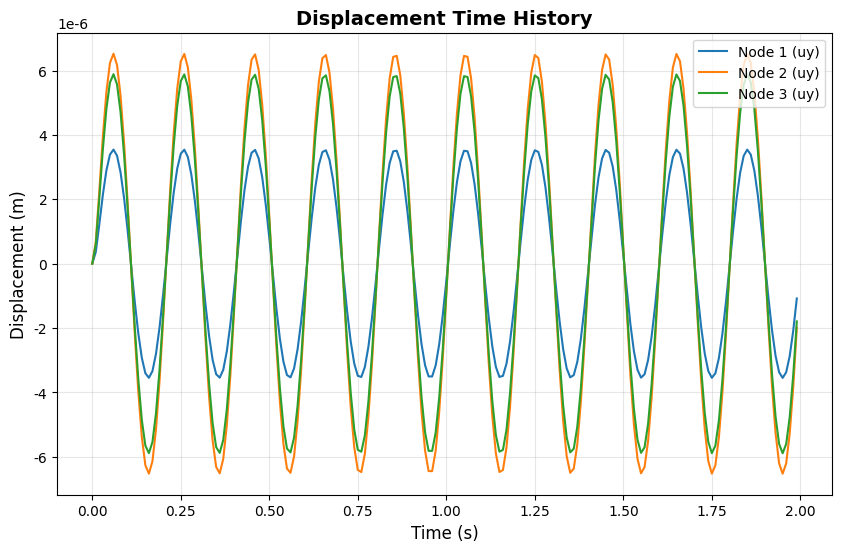

In [14]:
# 选择几个节点的位移显示
node_indices = [1, 2, 3]  # 节点1, 2, 3

disp_data = []
labels = []
for nid in node_indices:
    dof_uy = nodes[nid].dofs[1]
    disp_data.append(u_history[:, dof_uy])
    labels.append(f'Node {nid} (uy)')

plot_time_history(
    t, disp_data, labels,
    ylabel='Displacement (m)',
    title='Displacement Time History'
)

## 绘制速度时程

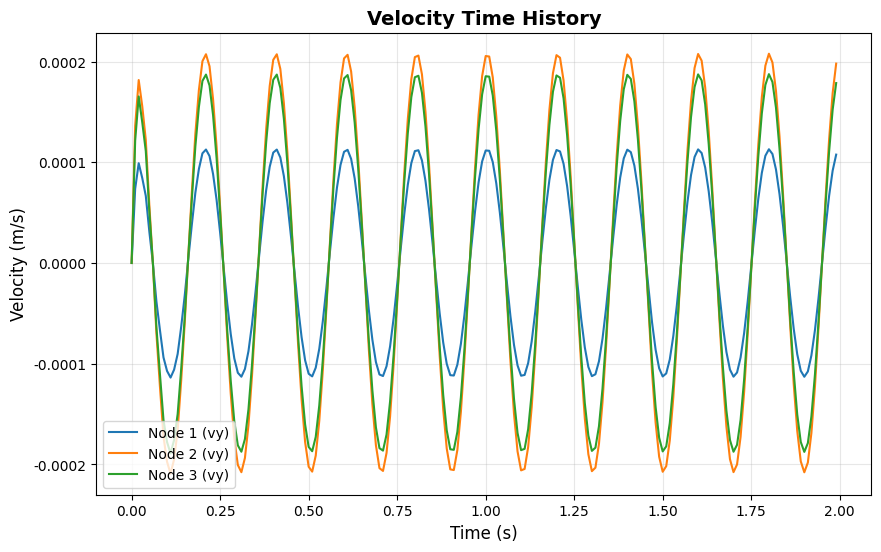

In [15]:
vel_data = []
labels = []
for nid in node_indices:
    dof_uy = nodes[nid].dofs[1]
    vel_data.append(v_history[:, dof_uy])
    labels.append(f'Node {nid} (vy)')

plot_time_history(
    t, vel_data, labels,
    ylabel='Velocity (m/s)',
    title='Velocity Time History'
)

## 绘制结构变形图

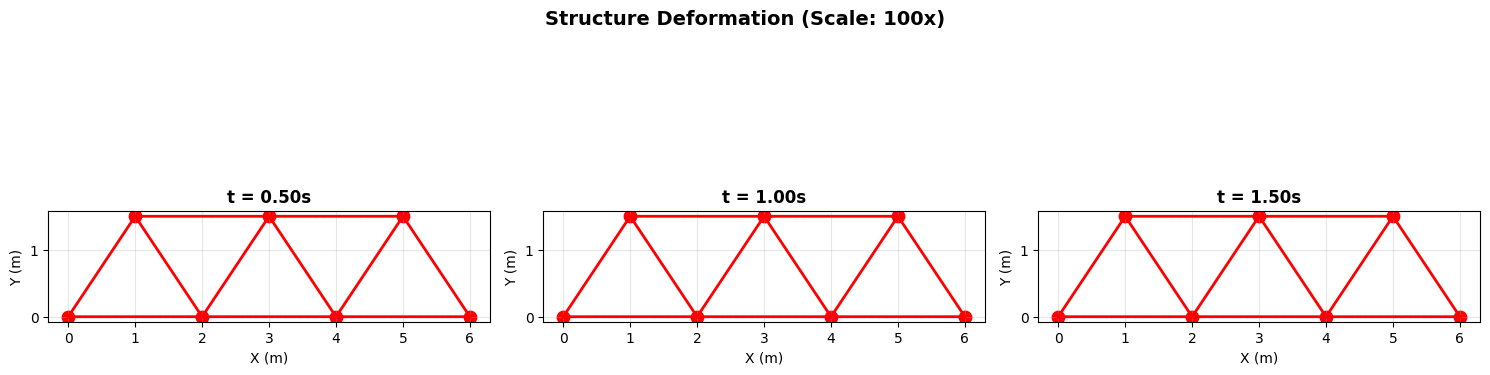

In [16]:
# 提取节点和单元数据
nodes_dict = {n['id']: n for n in structure['nodes']}
elements_dict = {e['id']: e for e in structure['elements']}

# 选取几个关键时刻的变形
time_indices = [50, 100, 150]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, t_idx in enumerate(time_indices):
    U = u_history[t_idx]
    
    # 绘制原始和变形结构
    x_orig = np.array([nodes_dict[n]['coords'][0] for n in nodes_dict])
    y_orig = np.array([nodes_dict[n]['coords'][1] for n in nodes_dict])
    
    scale = 100
    Ux = U[0::2]
    Uy = U[1::2]
    x_def = x_orig + Ux * scale
    y_def = y_orig + Uy * scale
    
    # 绘制单元
    for e in structure['elements']:
        n1, n2 = e['nodes']
        axes[idx].plot([x_orig[n1], x_orig[n2]], [y_orig[n1], y_orig[n2]], 'b--', alpha=0.3, linewidth=1)
        axes[idx].plot([x_def[n1], x_def[n2]], [y_def[n1], y_def[n2]], 'r-', linewidth=2)
    
    axes[idx].scatter(x_orig, y_orig, c='blue', s=50, alpha=0.5)
    axes[idx].scatter(x_def, y_def, c='red', s=80)
    axes[idx].set_title(f't = {t_idx * DT:.2f}s', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('X (m)')
    axes[idx].set_ylabel('Y (m)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal')

plt.suptitle('Structure Deformation (Scale: 100x)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()